In [161]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import seaborn.objects as so

import datetime
import warnings
warnings.filterwarnings('ignore')

# Chap 2. 시계열 데이터의 발견 및 다루기
- 시계열을 고려하지 않고 수집된 데이터에서 시계열 데이터를 발견하고 준비
- 타임스탬프가 초래하는 어려움 다루기

## 2.1 시계열 데이터는 어디서 찾는가
### 2.1.1 미리 준비된 데이터셋
- UCI Machine learning Repository, 정부 시계열 데이터셋(배우긴 어렵다)
- 일변량 : 시간에 대해 측정된 변수가 하나
- 다변량 : 각 타임스탬프에서 측정된 변수가 여러 개, 여러 변수가 서로 연관되거나, 각 변수가 서로 시간종속성

## 2.2 테이블 집합에서 시계열 데이터 집합 개선
### 2.2.1 시계열 데이터 집합 조립하기
- 사전관찰 : 미래의 어떤 사실을 앎 => 실제로 알아야 하는 시점보다 더 일찍 미래에 사실 발견, 문제
  - 해당 결과변수가 이전 기록까지 결과로 예측되는지, 해당 기록가지 포함하는지 판단 필요
- 특정 인덱스에 대한 기록이 하나 이상인지 확인
- 분석 대상에 따라 유사한 주기 설정 필요 ex. 사람: 일-토
- null 값 확인
- 시계열 데이터 작업 시, 계산에 반영되어야 하는 위치를 포함하는 것이 맞는지 확인 필요

In [82]:
# 특정 인덱스에 대한 기록이 하나 이상인지 확인
YearJoined = pd.read_csv("https://raw.githubusercontent.com/PracticalTimeSeriesAnalysis/BookRepo/master/Ch02/data/year_joined.csv")
emails = pd.read_csv("https://raw.githubusercontent.com/PracticalTimeSeriesAnalysis/BookRepo/master/Ch02/data/emails.csv")
donations = pd.read_csv("https://raw.githubusercontent.com/PracticalTimeSeriesAnalysis/BookRepo/master/Ch02/data/donations.csv")

YearJoined.groupby('user').count().groupby('userStats').count()

,yearJoined
userStats,
1,1000


In [83]:
# null값 처리 : set을 이용하여 각 열의 유니크한 값 목록 생성
complete_idx = pd.MultiIndex.from_product((set(emails['week']), set(emails['user'])))
all_email = emails.set_index(['week', 'user']).reindex(complete_idx, fill_value=0).reset_index() # NaN 0으로 채우기
all_email.columns = ['week','user','EmailsOpened']

# 회원가입 전 단계 0이 많으므로, 회원별로 회원가입 시점부터 데이터 구성
cutoff_dates = emails.groupby('user')['week'].agg(['min', 'max']).reset_index()
cutoff_dates = cutoff_dates.reset_index()

for _, row in cutoff_dates.iterrows():
    user = row['user']
    start_date = row['min']
    end_date = row['max']
    
    all_email.drop(all_email.loc[all_email['user'] == user][all_email['week'] < start_date].index, inplace=True)
    all_email.drop(all_email.loc[all_email['user'] == user][all_email['week'] > end_date].index, inplace=True)

all_email

,week,user,EmailsOpened
0,2018-02-12 00:00:00,1.0,0.0
2,2018-02-12 00:00:00,5.0,2.0
3,2018-02-12 00:00:00,6.0,1.0
4,2018-02-12 00:00:00,9.0,3.0
6,2018-02-12 00:00:00,14.0,0.0
...,...,...,...
93230,2017-03-13 00:00:00,958.0,0.0
93231,2017-03-13 00:00:00,959.0,0.0
93236,2017-03-13 00:00:00,970.0,2.0
93241,2017-03-13 00:00:00,987.0,2.0


### 2.2.2 발견된 시계열 구성하기
1) 해결하고자 하는 문제에 맞는 형태로 데이터 간격 교정 : 종종 필요 이상의 구체적 시간정보 제공
2) 사전 관찰 피하기 위해 가용 데이터를 생산하는 타임스탬프를 데이터데 사용하지 않는 방법 이해
3) 아무 일도 일어나지 않았더라도 관련된 모든 기간 기록 : 합계가 0 일지라도 다른 정보들 처럼 유익한 정보
4) 사전고나찰을 피하기 위해 : 아직 알아서는 안되는 정보를 생산하는 타임스탬프를 데이터에 사용하지 않음

In [85]:
donations['timestamp'] = pd.to_datetime(donations['timestamp'])
donations.set_index('timestamp', inplace=True)
# 주 단위 그룹화하여 기부금 총액을 구하고 dropna
agg_donations = donations.groupby('user').apply(lambda df : df['amount'].resample('W-Mon').sum().dropna())

# 이메일 정보와 합치기
merged_df = pd.DataFrame()
for user, user_email in all_email.groupby('user'):
    user_donations = agg_donations.loc[agg_donations.index.get_level_values('user') == user]
    user_donations = user_donations.droplevel(0)
    
    user_email = all_email.loc[all_email['user'] == user]
    user_email.set_index('week', inplace=True)
    user_email.sort_values('week', inplace=True)
    
    df = pd.merge(user_email, user_donations, how='left', left_index=True, right_index=True)
    df.fillna(0)
    
    merged_df = merged_df.append(df.reset_index()[['user', 'week', 'EmailsOpened', 'amount']])

# 기부 내역을 한 주 뒤로 옮김 => 한 주의 기부금은 발생 전 주의 입력변수의 결과
df = merged_df.loc[merged_df['user'] == 998]
df['target'] = df['amount'].shift(1)
df = df.fillna(0)
df.head()

,user,week,EmailsOpened,amount,target
0,998.0,2017-12-04 00:00:00,1.0,0.0,0.0
1,998.0,2017-12-11 00:00:00,3.0,0.0,0.0
2,998.0,2017-12-18 00:00:00,3.0,0.0,0.0
3,998.0,2017-12-25 00:00:00,0.0,0.0,0.0
4,998.0,2018-01-01 00:00:00,3.0,0.0,0.0


## 2.3 타임스탬프의 문제점
### 2.3.1 무엇에 대한 타임스탬프인가
- 생성 과정, 방법, 시기에 대한 질문
    - 발생 사건에 대한 기록은 실제로 일치하지 않는 경우가 많음
    
### 2.3.2 타임스탬프를 추측하여 데이터 이해
- 현지 시간과 세게 표준시간
    - 낮과 밤을 반영하여 데이터의 일일추세 확인
    - 빈번하게 발생한 요일과 시간을 안다면 사용가능 패턴 결정
- 사용자와 네트워크의 행동
    - 타임스탬프가 사용자의 행동에 대한 것인지, 네트워크 동작에 대한 것인지
    => 0의 집합을 파악해보거나, 각 사건에 대하여 질적인 결정 진행
    - 사용자 별 타임스탬프 간의 차이로 식사나 데이터 항목간 간격에 대한 감
    - 서버가 활성될 가능성이 높은 시점을 24시간 주기로 판단
    
### 2.3.3 의미있는 시간규모
- 연구 대상의 도메인에 대한 지식과 데이터의 상세한 수집 방식에 근거하여 다뤄져야 함
    - 기록자의 기억력 & 선천적 인지편향 => 오차를 줄이기 위해 평균화하거나, 더 긴 단위 변형 필요
    - 물리적 시스템의 한계 : 초 단위보다 빠른 변화

## 2.4 데이터 정리
### 2.4.1 데이터 누락
- 대치법 : 데이터셋 전체 기반하여 누락된 데이터 채우기 (bfill은 사전관찰)
    - forward fill : 누락값을 이전 추정으로 가져올 수 있다는 근거 필요, 계산이 복잡하지 않고 실시간 처리 가능
    - 이동평균 : 최근 여러 시간대를 입력, 전체 평균에 관한 개별 데이터값을 의심할 이유가 있으면 사용, 노이즈 일부 제거
- 보간법 : 인접한 데이터를 사용해 누락 데이터 추정
    - 선형보간 : 선형성의 가정을 유지한 채 데이터 추정
- 삭제 : 누락 기간을 사용하지 않음

- 데이터가 무작위로 누락될 가능성은 낮다. 많은 특징을 가진 열을 조사할 필요가 있다
- 누락된 데이터의 처리방법은 작업의 데이터 용도 설명 필요 : 사전관찰 생기지 않도록 조심

In [248]:
unemp = pd.read_csv("https://raw.githubusercontent.com/PracticalTimeSeriesAnalysis/BookRepo/master/Ch02/data/UNRATE.csv")
unemp['DATE'] = pd.to_datetime(unemp['DATE'])
unemp = unemp.groupby('DATE')['UNRATE'].sum().to_frame()
unemp.head()

,UNRATE
DATE,
1948-01-01,3.4
1948-02-01,3.8
1948-03-01,4.0
1948-04-01,3.9
1948-05-01,3.5


In [249]:
unemp_rand = unemp.drop(np.random.choice(unemp.index, size=int(0.1*len(unemp))), axis=0)
unemp_high = unemp.loc[list(unemp.index[unemp['UNRATE'] > 8])]
unemp_bias = unemp.loc[list(unemp.index[unemp['UNRATE'] <= 8])]

all_dates = pd.date_range(unemp.index[0], unemp.index[-1], freq='MS')
unemp_rand = pd.merge(unemp_rand, pd.DataFrame({'DATE' : all_dates}), on='DATE', how='right')
unemp_bias = pd.merge(unemp_bias, pd.DataFrame({'DATE' : all_dates}), on='DATE', how='right')
unemp_rand['rpt'] = unemp_rand['UNRATE'].isna()

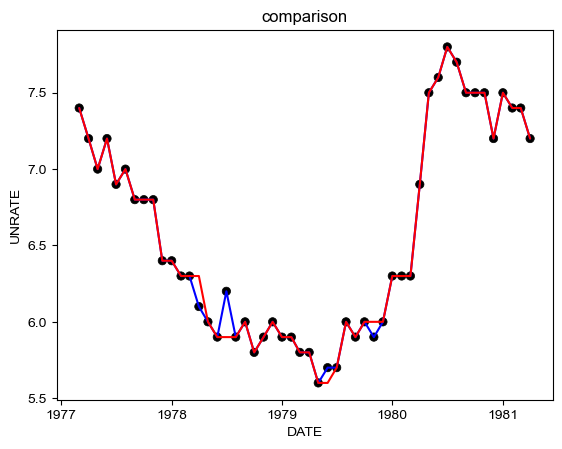

In [250]:
# Forward fill
unemp_ffill = unemp_rand.fillna(method='ffill')

temp = unemp.iloc[350:400,:]
temp_unemp_ffill = unemp_ffill.iloc[350:400, :].set_index('DATE')

fig, ax = plt.subplots()

plot = (
    so.Plot()
    .add(so.Line(color='blue'), x=temp.index, y=temp["UNRATE"], legend=True)
    .add(so.Dot(color='black'), x=temp.index, y=temp['UNRATE'])
    .add(so.Line(color='red'), x=temp.index, y=temp_unemp_ffill['UNRATE'], legend=True)
    .label(title='comparison', legend='imputation')
)

plot.on(ax).show()

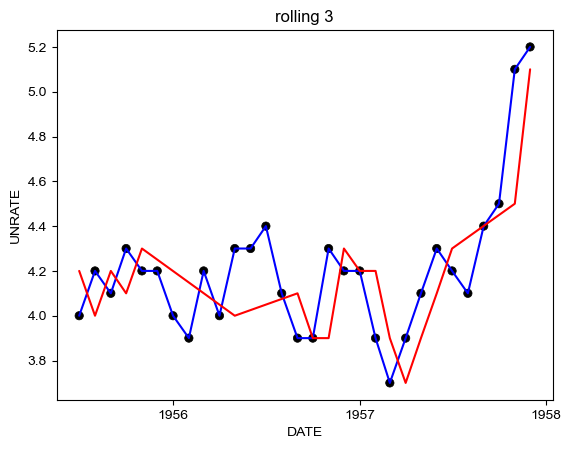

In [271]:
# moving average + nanmean + 2번째 자리 대치
unemp_roll = unemp_rand.copy()
unemp_roll['UNRATE'] = unemp_rand['UNRATE'].rolling(3, closed='left').apply(lambda x : x[2] if not np.isnan(x[2]) else np.nanmean(x), raw=True)

temp = unemp.iloc[90:120,:]
temp_unemp_roll = unemp_roll.iloc[90:120, :].set_index('DATE')

fig, ax = plt.subplots()

plot = (
    so.Plot()
    .add(so.Line(color='blue'), x=temp.index, y=temp["UNRATE"], legend=True)
    .add(so.Dot(color='black'), x=temp.index, y=temp['UNRATE'])
    .add(so.Line(color='red'), x=temp.index, y=temp_unemp_roll['UNRATE'], legend=True)
    .label(title='rolling 3', legend='imputation')
)

plot.on(ax).show()

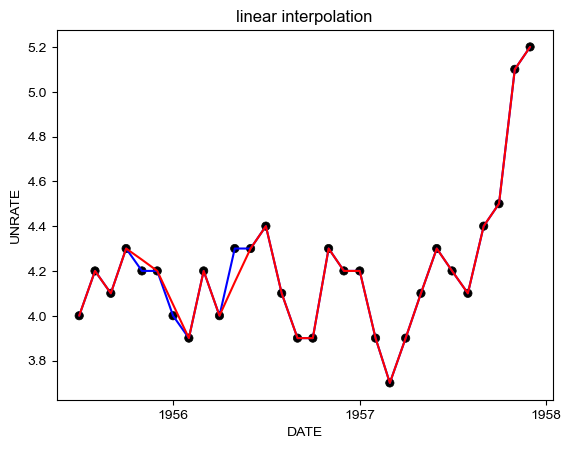

In [276]:
# interpolate
unemp_interp = unemp_rand.copy()
unemp_interp['UNRATE'] = unemp_rand['UNRATE'].interpolate(method='linear')
# unemp_interp['UNRATE'] = unemp_rand['UNRATE'].interpolate(method='spline', order=2)

temp = unemp.iloc[90:120,:]
temp_unemp_interp = unemp_interp.iloc[90:120, :].set_index('DATE')

fig, ax = plt.subplots()

plot = (
    so.Plot()
    .add(so.Line(color='blue'), x=temp.index, y=temp["UNRATE"], legend=True)
    .add(so.Dot(color='black'), x=temp.index, y=temp['UNRATE'])
    .add(so.Line(color='red'), x=temp.index, y=temp_unemp_interp['UNRATE'], legend=True)
    .label(title='linear interpolation', legend='imputation')
)

plot.on(ax).show()

### 2.4.2 업샘플링과 다운샘플링
- 타임스탬프의 빈도를 늘이거나 줄이기
- 다운샘플링
    - 원본 데이터의 시간 단위가 실용적이지 않은 경우
    - 계절 주기의 특정 부분에 집중하는 경우
    - 더 낮은 빈도의 데이터에 맞추는 경우
- 업샘플링 : 드물게 측정된 데이터에서 더 조밀한 시간의 데이터 추출
    - 시계열이 불규칙적인 상황
    - 입력이 서로 다른 빈도로 샘플링

In [283]:
# downsampling
unemp_rand.set_index('DATE').resample('Y').mean().head(3)

,UNRATE,rpt
DATE,,
1948-12-31,3.750000,0.000000
1949-12-31,6.172727,0.083333
1950-12-31,5.208333,0.000000


### 2.4.3 데이터 평활 (smoothing)
- 지수 평활 : 최근 데이터일 경우 더 많은 가중치를 줘 시간의 특성을 더 잘 인식
$$S_t=d\times S_{t-1} + (1-d)\times x_i$$
- 칼만필터 : 변동성 및 측정오차 조합 => 시간 전후 데이터 모두 고려하므로 과거로 정보유출 가능

In [321]:
air = pd.read_csv("https://raw.githubusercontent.com/PracticalTimeSeriesAnalysis/BookRepo/master/Ch02/data/AirPassengers.csv", names=['Date', 'Passengers'])

# alpha : 기존의 평균정보 유지하는 것에 비해 현재 값을 얼마나 갱신해야하는지. 클 수록 갱신은 현재 값에 가깝도록 갱신
air['Smooth.5'] = air.ewm(alpha = .5).Passengers.mean()

## 2.5 계절성 데이터
- 계절성 : 특정 행동의 빈도가 안정적으로 반복해서 나타나는 것
- 순환성 : 반복적인 동작을 보이나 기간이 가변적 ex) 화산 분출기

In [322]:
air = pd.read_csv("https://raw.githubusercontent.com/PracticalTimeSeriesAnalysis/BookRepo/master/Ch02/data/AirPassengers.csv", names=['Date', 'Passengers'])

so.Plot(data=air, x='Date', y='Passengers').add(so.Line()).add(so.Dots());

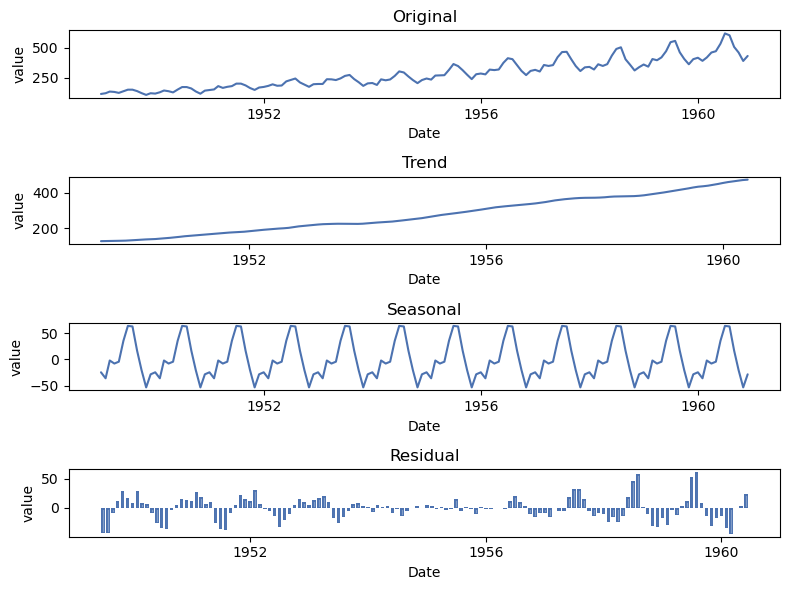

In [323]:
from statsmodels.tsa.seasonal import seasonal_decompose

air['Date'] = pd.to_datetime(air['Date'])
air = air.set_index('Date')
result = seasonal_decompose(air, model='additive', period=12)

fig, axes = plt.subplots(4,1, figsize=(8,6))

so.Plot(x=air.index, y=air['Passengers']).add(so.Line()).label(x='Date', y='value', title='Original').on(axes[0]).plot()
so.Plot(x=air.index, y=result.trend).add(so.Line()).label(x='Date', y='value', title='Trend').on(axes[1]).plot()
so.Plot(x=air.index, y=result.seasonal).add(so.Line()).label(x='Date', y='value', title='Seasonal').on(axes[2]).plot()
so.Plot(x=air.index, y=result.resid).add(so.Bar()).label(x='Date', y='value', title='Residual').on(axes[3]).plot()

plt.tight_layout()
plt.show()

## 2.6 시간대
- 고려 필요

## 2.7 사전관찰 방지
- 알려지지 않은 정직하지 못한 데이터 소유
- 가용데이터 끊임없는 판단 : 데이터 사이 지연시간, 데이터 샘플링 주기
    - 누락 데이터 대치 혹은 평활
    - 미리 매우 적은 데이터셋으로 전체공정 구축, 각 공정의 단계별 임의 지점 검사
    - 각 종류 데이터에 대해 각 타임스탬프와 관련된 지연 확인 (서버 업로드 시점과, 실제 발생 시점)
    - 시간을 인식할 수 있는 에러 검사 또는 교차검증
    - 의도적으로 사전고나찰을 도입하여 모델의 동작 확인
    - 특징이나 처리중인 특징을 천ㅊ너히 추가해서 성능의 큰 향상이 있는지 확인 => 특정 특징이 너무 좋은데 설명할 방법이 잘 없ㅇ르 경우